In [1]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.phy.config.seed = 42 # Set seed for reproducible random number generation

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sionna.phy import Block
from sionna.phy.mimo import StreamManagement
from sionna.phy.utils import sim_ber, ebnodb2no
from sionna.phy.mapping import Mapper, QAMSource, BinarySource
from sionna.phy.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, \
                            LMMSEInterpolator, LinearDetector, KBestDetector, \
                            EPDetector, MMSEPICDetector
from sionna.phy.channel import GenerateOFDMChannel, OFDMChannel, gen_single_sector_topology, set_3gpp_scenario_parameters
from sionna.phy.channel.tr38901 import UMa, Antenna, PanelArray
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder

In [2]:
NUM_OFDM_SYMBOLS = 14
FFT_SIZE = 12*4 # 4 PRBs
SUBCARRIER_SPACING = 30e3 # Hz
CARRIER_FREQUENCY = 10e9 # Hz
SPEED = 0 # m/s
Fs = FFT_SIZE * SUBCARRIER_SPACING
# The user terminals (UTs) are equipped with a single antenna
# with vertial polarization.
UT_ANTENNA = Antenna(polarization='single',
                     polarization_type='V',
                     antenna_pattern='omni', # Omnidirectional antenna pattern
                     carrier_frequency=CARRIER_FREQUENCY)

# The base station is equipped with an antenna
# array of 8 cross-polarized antennas,
# resulting in a total of 16 antenna elements.
NUM_RX_ANT = 16
BS_ARRAY = PanelArray(num_rows_per_panel=4,
                      num_cols_per_panel=2,
                      polarization='dual',
                      polarization_type='cross',
                      antenna_pattern='38.901', # 3GPP 38.901 antenna pattern
                      carrier_frequency=CARRIER_FREQUENCY)

# 3GPP UMa channel model is considered
channel_model = UMa(carrier_frequency=CARRIER_FREQUENCY,
                    o2i_model='low',
                    ut_array=UT_ANTENNA,
                    bs_array=BS_ARRAY,
                    direction='uplink',
                    enable_shadow_fading=False,
                    enable_pathloss=False)

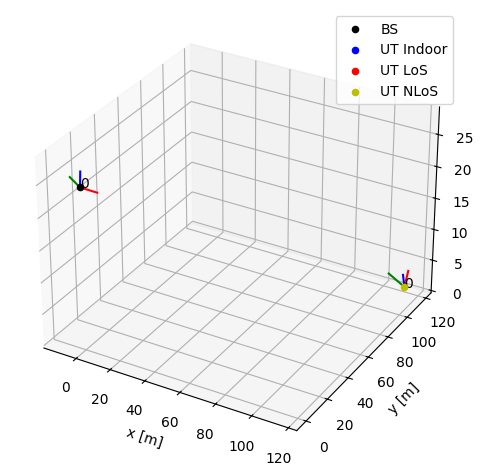

In [3]:
topology = gen_single_sector_topology(batch_size = 1,
                                      num_ut = 1,
                                      scenario = 'uma',
                                      indoor_probability = 0.1)
# Set the topology
ut_loc, bs_loc, ut_orientations, bs_orientations, ut_velocities, in_state = topology
channel_model.set_topology(ut_loc,
                           bs_loc,
                           ut_orientations,
                           bs_orientations,
                           ut_velocities,
                           in_state)
channel_model.show_topology()

In [4]:
a, tau = channel_model(1, sampling_frequency=Fs)

In [5]:
a.shape


TensorShape([1, 1, 16, 1, 1, 24, 1])

In [6]:
# # import numpy as np
# # import tensorflow as tf
# # import matplotlib.pyplot as plt

# # 1) Squeeze unnecessary dimensions
# #    a: [16, 24] -> Nr_ant x L
# #    tau: [24]   -> L
# a_s   = tf.squeeze(a)      
# tau_s = tf.squeeze(tau)    

# # 2) Filter out "dummy paths" (very small gain or unrealistic delays, e.g., 2.96s)
# eps = 1e-12
# mask_valid = (tau_s < 1.0) & tf.reduce_any(tf.abs(a_s) > eps, axis=0)  # [L]
# tau_v = tf.boolean_mask(tau_s, mask_valid)                   # [L_eff]
# a_v   = tf.transpose(tf.boolean_mask(tf.transpose(a_s), mask_valid))  # [Nr_ant, L_eff]

# # 3) Compute power of each path (sum over antennas; average is also possible)
# p_lin = tf.reduce_sum(tf.abs(a_v)**2, axis=0).numpy()        # [L_eff]
# p_db  = 10*np.log10(p_lin/np.max(p_lin) + 1e-20)

# # 4) Sort paths by delay
# idx = np.argsort(tau_v.numpy())
# tau_sorted = tau_v.numpy()[idx]
# p_db_sorted = p_db[idx]

# # 5) Plot "path gain vs. delay" (per-path version of PDP)
# plt.figure(figsize=(6,3.2))
# plt.stem(tau_sorted*1e6, p_db_sorted)

# # plt.setp(markerline, markersize=4)
# plt.xlabel('Delay [μs]')
# plt.ylabel('Path gain [dB, normalized]')
# plt.title('Per-path power vs delay')
# plt.grid(True, alpha=0.3)

# # 6) Print the earliest path (≈ LoS) information & compute K-factor
# print(f"Earliest path delay = {tau_sorted[0]*1e6:.3f} μs")
# K = p_lin[idx][0] / (np.sum(p_lin[idx][1:]) + 1e-20)
# print(f"Estimated K-factor ≈ {10*np.log10(K+1e-20):.2f} dB")


In [7]:
rg = ResourceGrid(num_ofdm_symbols=NUM_OFDM_SYMBOLS,
                  fft_size=FFT_SIZE,
                  subcarrier_spacing=SUBCARRIER_SPACING)
channel_sampler = GenerateOFDMChannel(channel_model, rg)

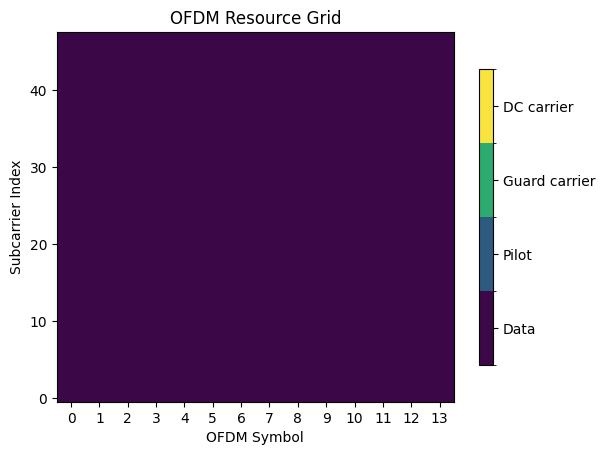

In [8]:
rg.show();

In [9]:
h_freq = channel_sampler()
# [batch size, num_rx_ant, num_ofdm_symbols, fft_size]
h_freq = h_freq[:,0,:,0,0]

In [10]:
import tensorflow as tf
import numpy as np
gen_ofdm_ch = GenerateOFDMChannel(channel_model, rg)




# Sample channel on the RG

H_freq = gen_ofdm_ch()            # shape [B, R, T=1, L, F]
shp    = tf.shape(H_freq)
B      = shp[0]; R = shp[1]; T = shp[2]; L = shp[3]; F = shp[4]


# Pilot placement (dynamic)
# Two full pilot symbols at time l=0 and l=L-1

pilot_power  = 1.0
pilot_symbol = tf.complex(tf.sqrt(tf.constant(pilot_power, tf.float32)), 0.0)

l0 = tf.constant(0, dtype=tf.int32)
l1 = L - 1

# time masks  [1,1,1,L,1]
mask0 = tf.reshape(tf.one_hot(l0, L, dtype=tf.float32), [1,1,1,L,1])
mask1 = tf.reshape(tf.one_hot(l1, L, dtype=tf.float32), [1,1,1,L,1])
time_mask = tf.clip_by_value(mask0 + mask1, 0.0, 1.0)

# Transmitted pilots at the receiver (broadcasted to [B,R,1,L,F] automatically)
X_for_rx = tf.complex(time_mask, 0.0) * pilot_symbol  # [1,1,1,L,1] -> bcasts

# Pass through channel + AWGN

SNR_dB  = 15.0
SNR_lin = 10.0**(SNR_dB/10.0)
N0      = pilot_power / SNR_lin

noise = tf.complex(
    tf.random.normal(tf.shape(H_freq), stddev=tf.sqrt(tf.constant(N0/2, tf.float32))),
    tf.random.normal(tf.shape(H_freq), stddev=tf.sqrt(tf.constant(N0/2, tf.float32)))
)
Y = H_freq * X_for_rx + noise  # [B,R,1,L,F]


# LS estimate on pilot REs

eps = tf.complex(tf.constant(1e-8, tf.float32), 0.0)
pilot_mask = tf.cast(time_mask > 0.0, tf.bool)  # [1,1,1,L,1]
H_LS = tf.where(
    pilot_mask,
    Y / (X_for_rx + eps),
    tf.complex(tf.zeros_like(Y, tf.float32), tf.zeros_like(Y, tf.float32))
)  # [B,R,1,L,F]


# Learn prior variance sigma_h^2(f,l) via Monte-Carlo (no noise)

K = 256
# template for [R,L,F]
template = tf.math.real(H_freq[0,:,0,:,:] * tf.math.conj(H_freq[0,:,0,:,:]))
h2_accum = tf.zeros_like(template)  # [R,L,F]
for _ in range(K):
    Hk = gen_ofdm_ch()              # [B,R,1,L,F]
    Hk = Hk[0,:,0,:,:]              # [R,L,F]
    h2_accum += tf.math.real(Hk * tf.math.conj(Hk))
sigma_h2 = h2_accum / float(K)      # [R,L,F]


# Bayesian (LMMSE) shrinkage on pilot REs
# alpha = sigma_h2 / (sigma_h2 + N0/|x|^2)

x_abs2 = tf.cast(tf.abs(pilot_symbol)**2, tf.float32)       # scalar
alpha  = sigma_h2 / (sigma_h2 + (N0 / tf.maximum(x_abs2, 1e-12)))   # [R,L,F]
alphaC = tf.complex(tf.expand_dims(alpha, axis=0), 0.0)             # [1,R,L,F]
alphaC = tf.expand_dims(alphaC, axis=2)                              # [1,R,1,L,F]

H_pilot_mmse = tf.where(
    pilot_mask, alphaC * H_LS,
    tf.complex(tf.zeros_like(H_LS, tf.float32), tf.zeros_like(H_LS, tf.float32))
)  # [B,R,1,L,F]


# Time-only interpolation between l0 and l1 (broadcasted, no scatter)
# Gather the two pilot slices (dynamic L)
H01 = tf.gather(H_pilot_mmse, tf.stack([l0, l1]), axis=3)  # [B,R,1,2,F]
H0  = H01[:,:,:,0,:]    # [B,R,1,F]
H1  = H01[:,:,:,1,:]    # [B,R,1,F]

# weights w(l) in [0,1] across L: w=0 at l0, w=1 at l1
denL = tf.maximum(1.0, tf.cast(L-1, tf.float32))
ls   = tf.cast(tf.range(L), tf.float32)
w    = tf.reshape(ls / denL, [1,1,1,L,1])                 # [1,1,1,L,1]
wC   = tf.complex(w, 0.0)

# Broadcast H0/H1 over time axis L by adding a length-1 time dim
H0b = tf.expand_dims(H0, axis=3)    # [B,R,1,1,F]
H1b = tf.expand_dims(H1, axis=3)    # [B,R,1,1,F]
H_hat = (1.0 - wC) * H0b + wC * H1b # [B,R,1,L,F]

# Enforce exact pilot slices **without scatters**: use masks
H_hat = H_hat * tf.complex(1.0 - (mask0 + mask1), 0.0) \
        + tf.complex(mask0, 0.0) * H0b \
        + tf.complex(mask1, 0.0) * H1b
# Shapes:
#  - mask0/mask1: [1,1,1,L,1] broadcast to [B,R,1,L,F]
#  - H0b/H1b:     [B,R,1,1,F] broadcast to [B,R,1,L,F]


# NMSE
num = tf.reduce_sum(tf.abs(H_freq - H_hat)**2)
den = tf.reduce_sum(tf.abs(H_freq)**2) + 1e-12
NMSE_dB = 10.0 * tf.math.log(num/den) / tf.math.log(10.0)
print("Bayesian (LMMSE) CE NMSE [dB]:", float(NMSE_dB.numpy()))
print("H_freq.shape:", H_freq.shape)
print("H_hat.shape:", H_hat.shape)




Bayesian (LMMSE) CE NMSE [dB]: -18.29876136779785
H_freq.shape: (1, 1, 16, 1, 1, 14, 48)
H_hat.shape: (1, 1, 16, 1, 1, 14, 48)


In [11]:
# # 1) Average RX SNR (measured on the two pilot symbols l=0 and l=L-1)
# H_pilots_true = tf.gather(H_freq, tf.stack([l0, l1]), axis=3)  # [B,R,1,2,F]
# Hgain = tf.reduce_mean(tf.math.real(H_pilots_true * tf.math.conj(H_pilots_true)))  # scalar
# snr_rx_lin = Hgain * (tf.cast(tf.abs(pilot_symbol)**2, tf.float32) / tf.constant(N0, tf.float32))
# snr_rx_db = 10.0 * tf.math.log(snr_rx_lin) / tf.math.log(10.0)
# print("Avg RX SNR on pilots [dB]:", float(snr_rx_db.numpy()))

# # 2) Baseline: LS + linear time interpolation (without LMMSE shrinkage)
# H01_ls = tf.gather(H_LS, tf.stack([l0, l1]), axis=3)  # [B,R,1,2,F]
# H0_ls  = H01_ls[:,:,:,0,:]                            # [B,R,1,F]
# H1_ls  = H01_ls[:,:,:,1,:]                            # [B,R,1,F]
# H0b_ls = tf.expand_dims(H0_ls, axis=3)                # [B,R,1,1,F]
# H1b_ls = tf.expand_dims(H1_ls, axis=3)                # [B,R,1,1,F]
# H_hat_ls = (1.0 - wC) * H0b_ls + wC * H1b_ls          # [B,R,1,L,F]

# # Ensure exact pilot values by using masks (avoids scatter operations)
# H_hat_ls = H_hat_ls * tf.complex(1.0 - (mask0 + mask1), 0.0) \
#            + tf.complex(mask0, 0.0) * H0b_ls \
#            + tf.complex(mask1, 0.0) * H1b_ls

# num_ls = tf.reduce_sum(tf.abs(H_freq - H_hat_ls)**2)
# den_ls = tf.reduce_sum(tf.abs(H_freq)**2) + 1e-12
# NMSE_dB_LS = 10.0 * tf.math.log(num_ls/den_ls) / tf.math.log(10.0)
# print("LS (interp) NMSE [dB]:", float(NMSE_dB_LS.numpy()))

# # 3) Bayesian LMMSE + interpolation NMSE (as before)
# num = tf.reduce_sum(tf.abs(H_freq - H_hat)**2)
# den = tf.reduce_sum(tf.abs(H_freq)**2) + 1e-12
# NMSE_dB = 10.0 * tf.math.log(num/den) / tf.math.log(10.0)
# print("Bayesian (LMMSE) CE NMSE [dB]:", float(NMSE_dB.numpy()))
# print("H_freq shape:", H_freq.shape)
# print("H_hat  shape:", H_hat.shape)
